# Exercise 7
## Céline Budding && Dorothea Müller 

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

%matplotlib inline

## 1. The 10-armed bandit

### 1.

In [2]:
reward_prob = np.random.uniform(0, 0.9, 10)
reward_prob

array([0.38887817, 0.56654381, 0.37615114, 0.8798296 , 0.18296413,
       0.64165971, 0.89231978, 0.84453306, 0.4454207 , 0.71544274])

### 2.

In [3]:
def generate_reward(reward_prob, lever_numbers):
    rewards = np.zeros(len(lever_numbers))
    for i, lever_number in enumerate(lever_numbers):
        if np.random.random() > reward_prob[lever_number]:
            rewards[i] = 0
        else:
            rewards[i] = 1
    return rewards

In [4]:
# Testing.
n = 10000
received_rewards = np.zeros(len(reward_prob))
for i in range(n):
    received_rewards += generate_reward(reward_prob, np.arange(0, 10))
received_rewards/=n

In [5]:
received_rewards

array([0.3887, 0.5668, 0.377 , 0.8779, 0.1745, 0.6348, 0.8917, 0.8417,
       0.4348, 0.7104])

### 3.

In [6]:
# def update_q(reward_prob, q, eta = 0.01):
#     delta_q = eta * (generate_reward(reward_prob, np.arange(0, len(reward_prob))) - q)
#     q = q + delta_q
#     return q

In [7]:
def update_q(reward, pos, q, eta = 0.01):
    delta_q = eta * (reward - q[pos])
    q[pos] += delta_q
    return q

In [8]:
q = np.zeros(len(reward_prob))
q

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
for i in range(n):
    # Pulling the levers at all positions.
    q = update_q(reward_prob, np.arange(len(q)), q)
q

array([0.38887817, 0.56654381, 0.37615114, 0.8798296 , 0.18296413,
       0.64165971, 0.89231978, 0.84453306, 0.4454207 , 0.71544274])

### 4.

In [20]:
def eps_greedy(q, eps):
    """Return lever(s) to be pressed, q value of chosen lever, largest q value."""
    if np.random.random() < 1-eps:
        # Get all the maxima.
        pos = np.argwhere(q == np.amax(q)).flatten()
        val = np.take(q, pos, 0)[0]
        largest_val = val
    else:
        pos = np.random.randint(0, len(q))
        val = q[pos]
        largest_val = q[np.argmax(q)]
        
    return [pos, val, largest_val]

### 5.

In [27]:
def pure_greedy_seq():
    q = np.zeros(len(reward_prob))

    n = 1000
    expected_reward = np.zeros(n)

    for i in range(n):
        levers = eps_greedy(q, 0)
        pos = levers[0]
        reward = generate_reward(reward_prob, pos)
        q = update_q(reward, pos, q)

        expected_reward[i] = levers[1]
    
    return expected_reward

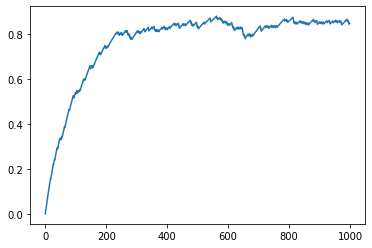

In [31]:
expected_reward = pure_greedy_seq()
plt.plot(expected_reward)

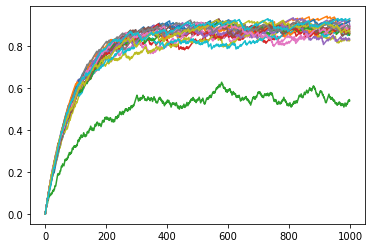

In [32]:
for i in range(20):
    expected_reward = pure_greedy_seq()
    plt.plot(expected_reward)